# Pre-processing CelebA as a biased-exposure dataset

In [2]:
%matplotlib inline
from IPython.display import display, HTML

import itertools
import gdown
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from exposure_bias.data.base import ExposureCondition
from exposure_bias.data.base import threshold_attribute_combos
from exposure_bias.data import BiasedExposureCelebA

def p(df):
    display(HTML(df.to_html()))

Get the CelebA meta-data.

In [3]:
attr_path = os.path.join('/tmp', 'list_attr_celeba.txt')
valid_path = os.path.join('/tmp', 'list_eval_partition.txt')

# Try downloading the attribute data.
try:
    train_images, valid_images, test_images, attr = BiasedExposureCelebA._extract_celeba(
        valid_path, attr_path)
except:
    try:
        gdown.download(tfds.image.celeba.ATTR_DATA, attr_path, quiet=False)
        train_images, valid_images, test_images, attr = BiasedExposureCelebA._extract_celeba(
            valid_path, attr_path)
    except:
        gdown.download(tfds.image.celeba.EVAL_LIST, attr_path, quiet=False)
        train_images, valid_images, test_images, attr = BiasedExposureCelebA._extract_celeba(
            valid_path, attr_path)

train_attr = np.vstack(list(attr[image] for image in train_images)) > 0
valid_attr = np.vstack(list(attr[image] for image in valid_images)) > 0
test_attr = np.vstack(list(attr[image] for image in test_images)) > 0

## Part I: Select attributes to define the training conditions

Some helper functions.

In [4]:
def compute_overlap(combo_a, combo_b):
    (attr_a_i, attr_a_j) = combo_a
    values_a = np.vstack((train_attr[:, attr_a_i], train_attr[:, attr_a_j]))
    
    (attr_b_i, attr_b_j) = combo_b
    values_b = np.vstack((train_attr[:, attr_b_i], train_attr[:, attr_b_j]))
    
    def normalize(a, b, c, d):
        return ((a & b & c & d).sum() /
            ((a & b).sum() + (c & d).sum()))
    
    not_x_not_y = normalize(~(values_a[0, :]), ~(values_a[1, :]), ~(values_b[0, :]), ~(values_b[1, :]))
    not_x_y = normalize(~(values_a[0, :]), (values_a[1, :]), ~(values_b[0, :]), (values_b[1, :]))
    x_not_y = normalize((values_a[0, :]), ~(values_a[1, :]), (values_b[0, :]), ~(values_b[1, :]))
    x_y = normalize((values_a[0, :]), (values_a[1, :]), (values_b[0, :]), (values_b[1, :]))  
    
    overlap = (values_a == values_b).all(axis=0).sum()
    overlap /= values_a.shape[1] * 2
    print(f'Attribute pairs {tfds.image.celeba.ATTR_HEADINGS[attr_a_i]}+{tfds.image.celeba.ATTR_HEADINGS[attr_a_j]}'
          f' and {tfds.image.celeba.ATTR_HEADINGS[attr_b_i]}+{tfds.image.celeba.ATTR_HEADINGS[attr_b_j]}'
          f' have \x1b[31m{overlap * 100:.0f}%\x1b[0m overall overlap:')
    print(f'\tnot a & b:\t{not_x_y * 100:.0f}% \t\ta & b:\t\t{x_y * 100:.0f}%')
    print(f'\tnot a & not b:\t{not_x_not_y * 100:.0f}% \t\ta & not b:\t{x_not_y * 100:.0f}%')
    
    
def threshold_attributes(train_threshold, eval_threshold):
    train_thresholded_attr_combos = threshold_attribute_combos(train_attr, train_threshold)
    valid_thresholded_attr_combos = threshold_attribute_combos(valid_attr, eval_threshold)
    test_thresholded_attr_combos = threshold_attribute_combos(test_attr, eval_threshold)

    i = 0
    verified_combos = []
    print('Valid cliques:')
    for clique in train_thresholded_attr_combos:
        i += 1
        in_test = (any(clique.issubset(valid_clique) for valid_clique in valid_thresholded_attr_combos) and
                   any(clique.issubset(test_clique) for test_clique in test_thresholded_attr_combos))
        if in_test:
            print(f'\tClique {i}:', list(tfds.image.celeba.ATTR_HEADINGS[attr] for attr in clique))
            verified_combos += [clique]
            
    return verified_combos

### Attempt 3: Investigate the attribute distributions

#### Unary counts

We find attributes that approximately split the dataset into two.

In [85]:
train_df = pd.DataFrame(train_attr, columns=tfds.image.celeba.ATTR_HEADINGS)
valid_df = pd.DataFrame(valid_attr, columns=tfds.image.celeba.ATTR_HEADINGS)
test_df = pd.DataFrame(test_attr, columns=tfds.image.celeba.ATTR_HEADINGS)

def count_bounds(df):
    num_total = len(df)
    tolerance = num_total * 0.1
    return (num_total // 2) - tolerance, (num_total // 2) + tolerance

train_lower_bound, train_upper_bound = count_bounds(train_df)

all_df = pd.concat((train_df.sum(), valid_df.sum(), test_df.sum()), axis=1, keys=('train', 'valid', 'test')).sort_values('train', ascending=False)
np.logical_and(train_lower_bound < all_df["train"], all_df["train"] < train_upper_bound)

No_Beard               False
Young                  False
Attractive              True
Mouth_Slightly_Open     True
Smiling                 True
Wearing_Lipstick        True
High_Cheekbones         True
Male                    True
Heavy_Makeup           False
Wavy_Hair              False
Oval_Face              False
Pointy_Nose            False
Arched_Eyebrows        False
Big_Lips               False
Black_Hair             False
Big_Nose               False
Straight_Hair          False
Bags_Under_Eyes        False
Brown_Hair             False
Wearing_Earrings       False
Bangs                  False
Blond_Hair             False
Bushy_Eyebrows         False
Wearing_Necklace       False
Narrow_Eyes            False
5_o_Clock_Shadow       False
Receding_Hairline      False
Wearing_Necktie        False
Rosy_Cheeks            False
Eyeglasses             False
Goatee                 False
Chubby                 False
Sideburns              False
Blurry                 False
Wearing_Hat   

#### Binary counts

For these attributes, we check which pairs evenly split the dataset into four quadrants.

In [141]:
valid_attrs = ("Attractive",
"Mouth_Slightly_Open",
"Smiling",
"Wearing_Lipstick",
"High_Cheekbones",
"Male",
)

def count_all_quadrants(attr, combos):
    quadrant_counts = []
    for (i, j) in combos:
        quadrant_counts.append((
            np.logical_and(np.logical_not(attr[:, i]), np.logical_not(attr[:, j])).sum(),
            np.logical_and(attr[:, i], np.logical_not(attr[:, j])).sum(),
            np.logical_and(np.logical_not(attr[:, i]), attr[:, j]).sum(), 
            np.logical_and(attr[:, i], attr[:, j]).sum(),
        ))
    return quadrant_counts

valid_combos = list(itertools.combinations((tfds.image.celeba.ATTR_HEADINGS.index(attr) for attr in valid_attrs), 2))
combo_attrs = list((tfds.image.celeba.ATTR_HEADINGS[idx_a], tfds.image.celeba.ATTR_HEADINGS[idx_b]) for 
               idx_a, idx_b in valid_combos)
binary = pd.DataFrame(
    data=pd.concat((pd.DataFrame(combo_attrs), pd.DataFrame(count_all_quadrants(train_attr, valid_combos))), axis=1), 
    #columns=('attr', 'off_off', 'on_off', 'off_on', 'on_on')
)

p(binary)
#binary = pd.DataFrame(
#    data=((combo[0], combo[1], (train_df[combo[0]] & train_df[combo[1]]).sum()) for combo in combos),
#    columns=('attr_a', 'attr_b', 'count'))
#binary = binary[binary['count'] < 1000]
#p(binary.sort_values('count', ascending=True))

### Attempt 2: Use a maximal clique

Pro: attributes have joint support; con: conditions might overlaps in terms of images, and need to use a lower threshold for train.

First, we check which attribute combos has sufficient support at a threshold of 20K images, and select a maximal clique.

In [5]:
verified_combos = threshold_attributes(20000, 1000)
verified_combos = list(itertools.combinations(sorted(verified_combos, key=lambda x: -len(x))[0], 2))
print()
print('Combinations resulting from a maximal clique:')
for i, clique in enumerate(verified_combos):
    print(f'\tClique {i + 1}:', list(tfds.image.celeba.ATTR_HEADINGS[attr] for attr in clique))

Valid cliques:
	Clique 1: ['Arched_Eyebrows', 'Mouth_Slightly_Open', 'Wavy_Hair']
	Clique 2: ['Wavy_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open']
	Clique 3: ['Attractive', 'High_Cheekbones', 'Mouth_Slightly_Open']
	Clique 4: ['High_Cheekbones', 'Wearing_Lipstick', 'Mouth_Slightly_Open']
	Clique 5: ['High_Cheekbones', 'Male', 'Mouth_Slightly_Open']
	Clique 6: ['Pointy_Nose', 'High_Cheekbones', 'Mouth_Slightly_Open']
	Clique 7: ['Oval_Face', 'Heavy_Makeup', 'Mouth_Slightly_Open']
	Clique 8: ['Wavy_Hair', 'Heavy_Makeup', 'Smiling']
	Clique 9: ['Attractive', 'Smiling']
	Clique 10: ['Wearing_Lipstick', 'Smiling']
	Clique 11: ['Male', 'Smiling']
	Clique 12: ['Pointy_Nose', 'Smiling']

Combinations resulting from a maximal clique:
	Clique 1: ['Wavy_Hair', 'Heavy_Makeup']
	Clique 2: ['Wavy_Hair', 'High_Cheekbones']
	Clique 3: ['Wavy_Hair', 'Mouth_Slightly_Open']
	Clique 4: ['Heavy_Makeup', 'High_Cheekbones']
	Clique 5: ['Heavy_Makeup', 'Mouth_Slightly_Open']
	Clique 6: ['Hig

Then, we check that these combos don't overlap too much in their examples.

In [6]:
for combo_a, combo_b in itertools.combinations(verified_combos, 2):
    compute_overlap(combo_a, combo_b)

Attribute pairs Wavy_Hair+Heavy_Makeup and Wavy_Hair+High_Cheekbones have 32% overall overlap:
	not a & b:	24% 		a & b:		34%
	not a & not b:	36% 		a & not b:	29%
Attribute pairs Wavy_Hair+Heavy_Makeup and Wavy_Hair+Mouth_Slightly_Open have 28% overall overlap:
	not a & b:	19% 		a & b:		31%
	not a & not b:	32% 		a & not b:	26%
Attribute pairs Wavy_Hair+Heavy_Makeup and Heavy_Makeup+High_Cheekbones have 23% overall overlap:
	not a & b:	0% 		a & b:		29%
	not a & not b:	36% 		a & not b:	0%
Attribute pairs Wavy_Hair+Heavy_Makeup and Heavy_Makeup+Mouth_Slightly_Open have 19% overall overlap:
	not a & b:	0% 		a & b:		27%
	not a & not b:	33% 		a & not b:	0%
Attribute pairs Wavy_Hair+Heavy_Makeup and High_Cheekbones+Mouth_Slightly_Open have 18% overall overlap:
	not a & b:	6% 		a & b:		17%
	not a & not b:	26% 		a & not b:	5%
Attribute pairs Wavy_Hair+High_Cheekbones and Wavy_Hair+Mouth_Slightly_Open have 35% overall overlap:
	not a & b:	34% 		a & b:		36%
	not a & not b:	37% 		a & not b:	35%
Att

### Attempt 1: Combine disjoint maximal cliques

Pro: can use a higher threshold for train; con: attribute combos are at least partially disjoint, so less control over experimental condition is possible.

In [7]:
verified_combos = threshold_attributes(30000, 1000)

Valid cliques:
	Clique 1: ['Attractive', 'Mouth_Slightly_Open']
	Clique 2: ['Attractive', 'Smiling']
	Clique 3: ['Wearing_Lipstick', 'Mouth_Slightly_Open']
	Clique 4: ['Wearing_Lipstick', 'Smiling']


In [8]:
for combo_a, combo_b in itertools.combinations(verified_combos, 2):
    compute_overlap(combo_a, combo_b)

Attribute pairs Attractive+Mouth_Slightly_Open and Attractive+Smiling have 38% overall overlap:
	not a & b:	36% 		a & b:		40%
	not a & not b:	39% 		a & not b:	39%
Attribute pairs Attractive+Mouth_Slightly_Open and Wearing_Lipstick+Mouth_Slightly_Open have 37% overall overlap:
	not a & b:	37% 		a & b:		38%
	not a & not b:	38% 		a & not b:	36%
Attribute pairs Attractive+Mouth_Slightly_Open and Wearing_Lipstick+Smiling have 28% overall overlap:
	not a & b:	24% 		a & b:		31%
	not a & not b:	31% 		a & not b:	26%
Attribute pairs Attractive+Smiling and Wearing_Lipstick+Mouth_Slightly_Open have 28% overall overlap:
	not a & b:	25% 		a & b:		30%
	not a & not b:	30% 		a & not b:	26%
Attribute pairs Attractive+Smiling and Wearing_Lipstick+Smiling have 37% overall overlap:
	not a & b:	34% 		a & b:		38%
	not a & not b:	39% 		a & not b:	35%
Attribute pairs Wearing_Lipstick+Mouth_Slightly_Open and Wearing_Lipstick+Smiling have 38% overall overlap:
	not a & b:	36% 		a & b:		39%
	not a & not b:	40% 		a

### Decision: Use attempt 3

Use the following pairs, which evenly divide the dataset:
['Wearing_Lipstick', 'Mouth_Slightly_Open']
['Male', 'Mouth_Slightly_Open']

We also reserve the last combination, which produces a natural "partial exposure" effect:
['Wearing_Lipstick', 'Male']

## Sanity-check exposure conditions

In [9]:
def visualize_dataset(title, dataset, N=9):
    assert math.isqrt(N)
    
    # Prepare the plot.
    grid_size = int(np.sqrt(N))
    fig = plt.figure(figsize=(grid_size*5, grid_size*5))
    fig.suptitle(title, fontweight='bold', y=0.92, fontsize=14)
    outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
    
    axs_idx = [[outer[2], outer[0]], [outer[3], outer[1]]]
    axs = [
        [
            gridspec.GridSpecFromSubplotSpec(grid_size, grid_size,
                        subplot_spec=axs_idx[0][0], wspace=0.1, hspace=0.1),
            gridspec.GridSpecFromSubplotSpec(grid_size, grid_size,
                        subplot_spec=axs_idx[0][1], wspace=0.1, hspace=0.1),
         ], [
            gridspec.GridSpecFromSubplotSpec(grid_size, grid_size,
                        subplot_spec=axs_idx[1][0], wspace=0.1, hspace=0.1),
            gridspec.GridSpecFromSubplotSpec(grid_size, grid_size,
                        subplot_spec=axs_idx[1][1], wspace=0.1, hspace=0.1),
         ] 
        ]
    
    for discriminator_idx in range(2):
        for distractor_idx in range(2):
            title = "discriminator = {}; distractor = {}".format(discriminator_idx, distractor_idx)
            plt.subplot(axs_idx[discriminator_idx][distractor_idx]).title.set_text(title)
        
    example_counts = np.zeros((2, 2), int)
    np_iterator = dataset.as_numpy_iterator()
    
    # Plot the examples.
    try:
        while np.sum(example_counts) < 4 * N:
            example = next(np_iterator)
            discriminator_idx = example['discriminator']
            distractor_idx = example['distractor']
            
            if example_counts[discriminator_idx, distractor_idx] >= N:
                continue
            
            subplot = axs[discriminator_idx][distractor_idx]
            ax = plt.Subplot(fig, subplot[example_counts[discriminator_idx, distractor_idx]])
            im = ax.imshow(example['image'])
            ax.axis('off')
            
            fig.add_subplot(ax)
            example_counts[discriminator_idx, distractor_idx] += 1
    except StopIteration:
        pass
    
    # Fill in the empty spots.
    blank_image = np.zeros_like(example['image'])
    for discriminator_idx in range(2):
        for distractor_idx in range(2):

            subplot = axs[discriminator_idx][distractor_idx] 
            while example_counts[discriminator_idx, distractor_idx] < N:
                ax = plt.Subplot(fig, subplot[example_counts[discriminator_idx, distractor_idx]])
                im = ax.imshow(blank_image)
                
                if example_counts[discriminator_idx, distractor_idx] == N:
                    subplot_ax.set_ylabel("discriminator={}, distractor={}".format(
                discriminator_idx, distractor_idx), fontsize=9)
                ax.axis('off')
                    
                
                fig.add_subplot(ax)
                example_counts[discriminator_idx, distractor_idx] += 1
    
    plt.show()

In [10]:
cfg = BiasedExposureCelebA.BUILDER_CONFIGS[0]  # pick any config
exposure_condition = cfg.exposure_condition.name.lower()

### Training condition: Zero-shot

Dataset: biased_exposure_celeb_a/CelebA-zero_shot-relative_balance-discriminator_Wavy_Hair-distractor_Heavy_Makeup


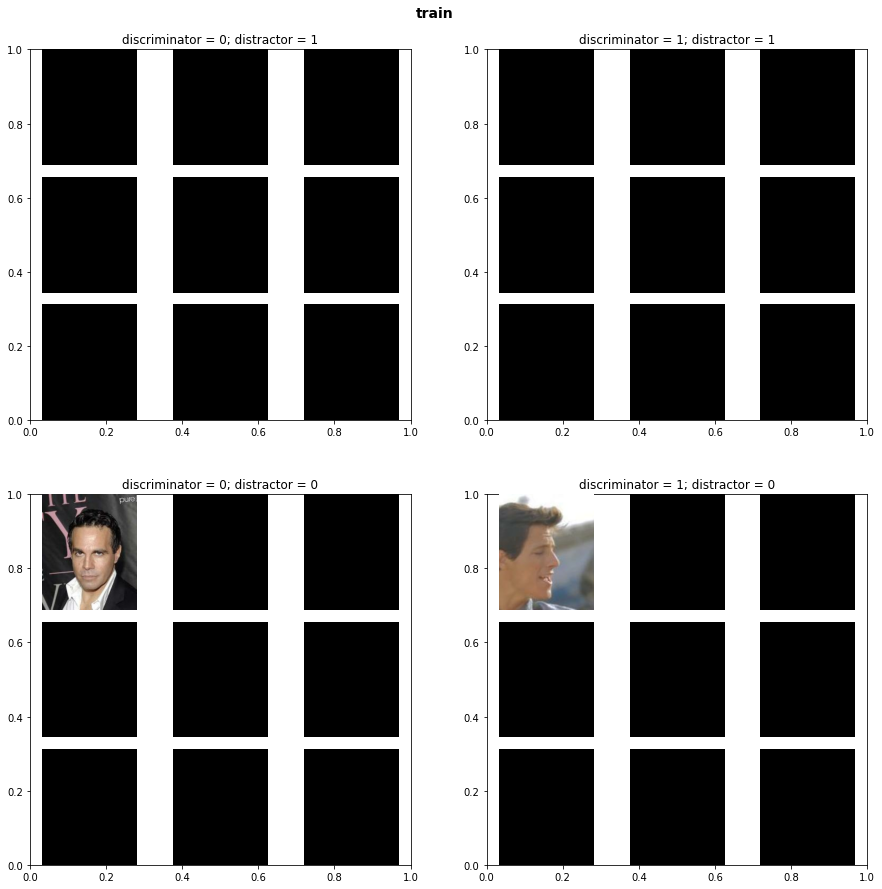

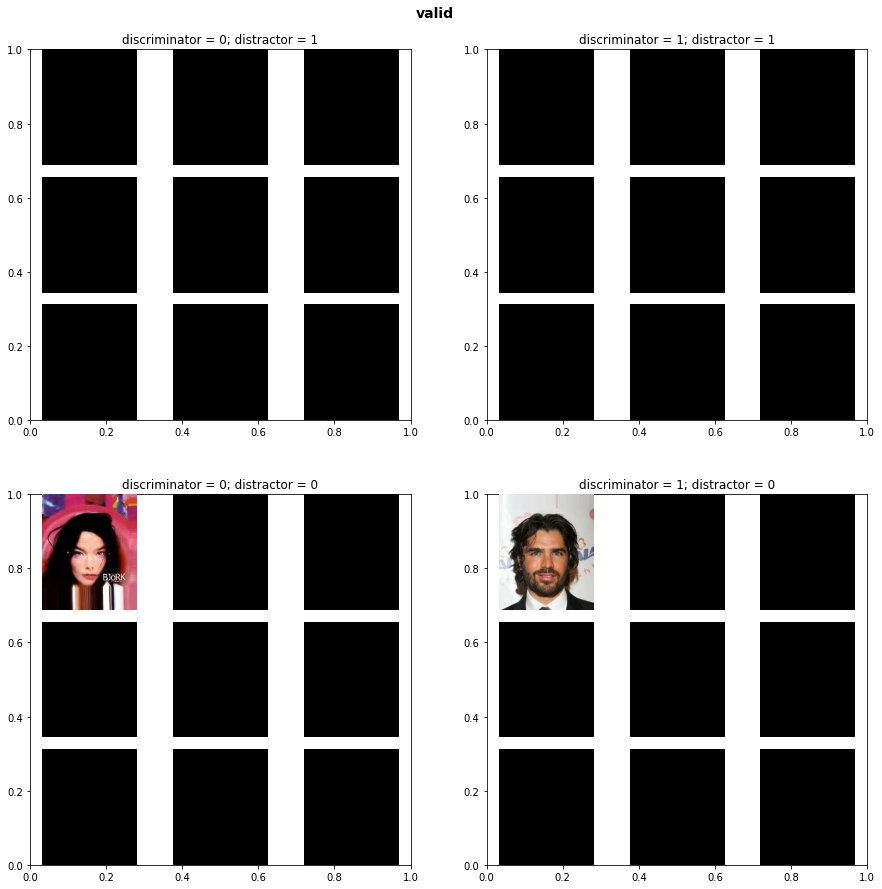

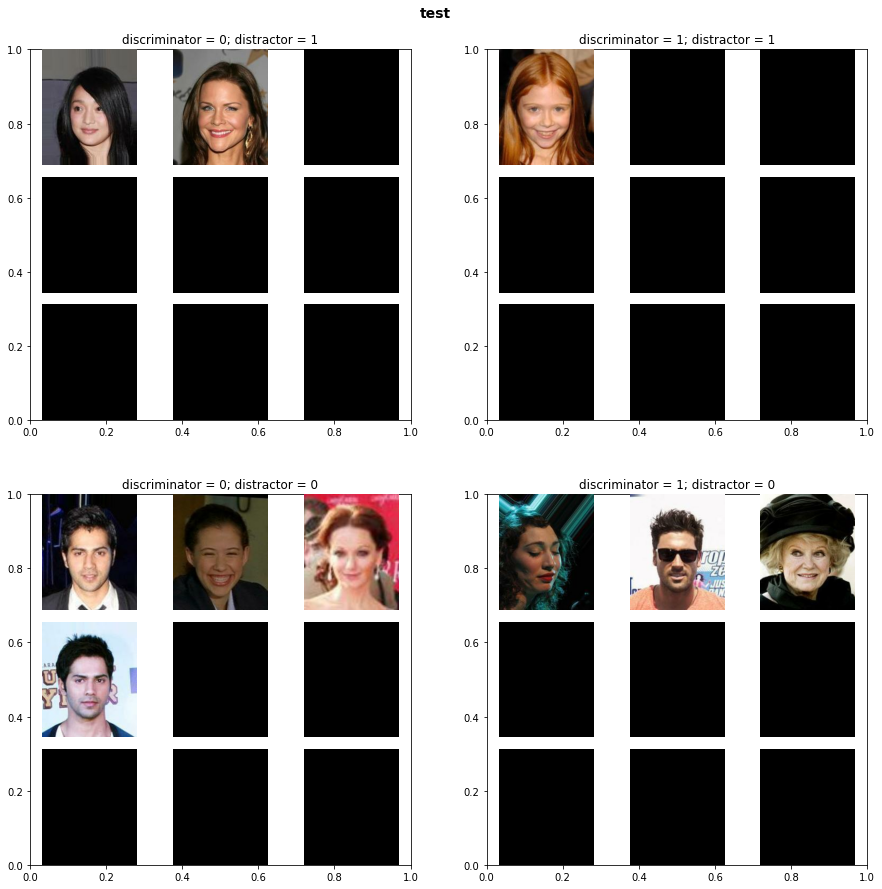

In [11]:
condition = ExposureCondition.ZERO_SHOT.name.lower()

dataset_name = 'biased_exposure_celeb_a/' + cfg.name.replace(exposure_condition, condition)
print(f'Dataset: {dataset_name}')
for split in ['train', 'valid', 'test']:
    visualize_dataset(split,
                      tfds.load(dataset_name, split=split))
    print()
    print()

### Training condition: Cue conflict

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/Users/eringrant/code/exposure-bias/exposure_bias/data/celeb_a.py:207: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  train_attributes = np.vstack(
/Users/eringrant/code/exposure-bias/exposure_bias/data/celeb_a.py:210: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  valid_attributes = np.vstack(
/Users/eringrant/code/exposure-bias/exposure_bias/data/celeb_a.py:213: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  test_attributes = np.vstack(


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-train.tfrecord...:   0%|          | 0/39859 [00:00<?, ? examples/s]

Generating valid examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-valid.tfrecord...:   0%|          | 0/3892 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-test.tfrecord...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Dataset biased_exposure_celeb_a downloaded and prepared to /Users/eringrant/tensorflow_datasets/biased_exposure_celeb_a/CelebA-cue_conflict-relative_balance-discriminator_Wavy_Hair-distractor_Heavy_Makeup/0.0.1. Subsequent calls will reuse this data.


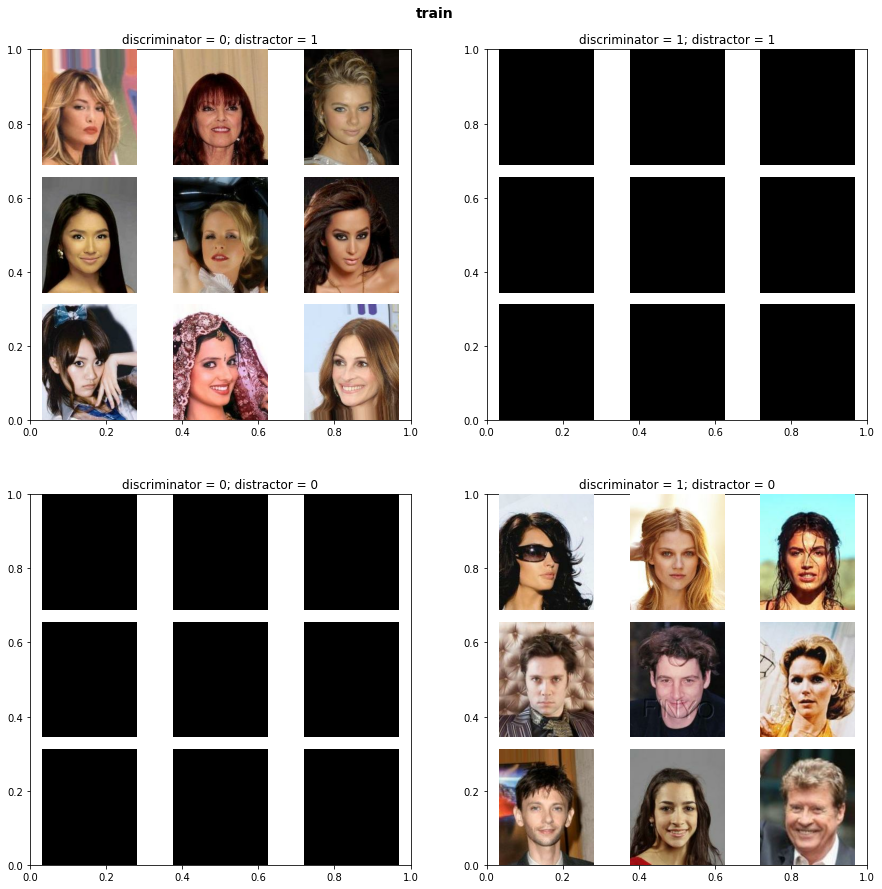

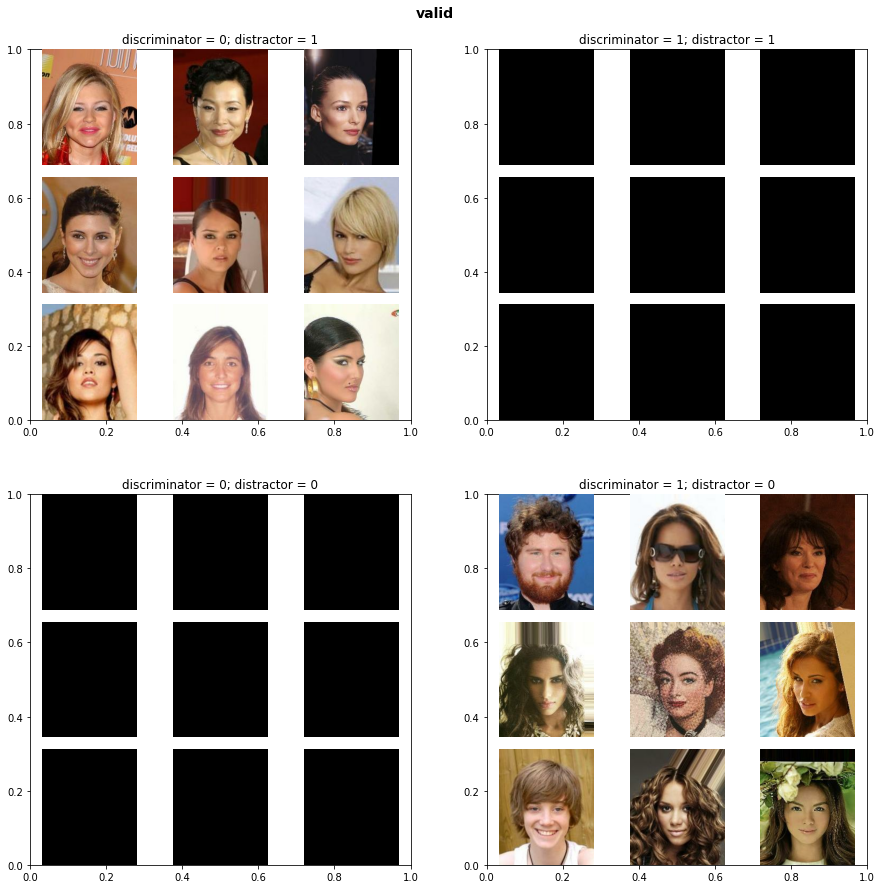

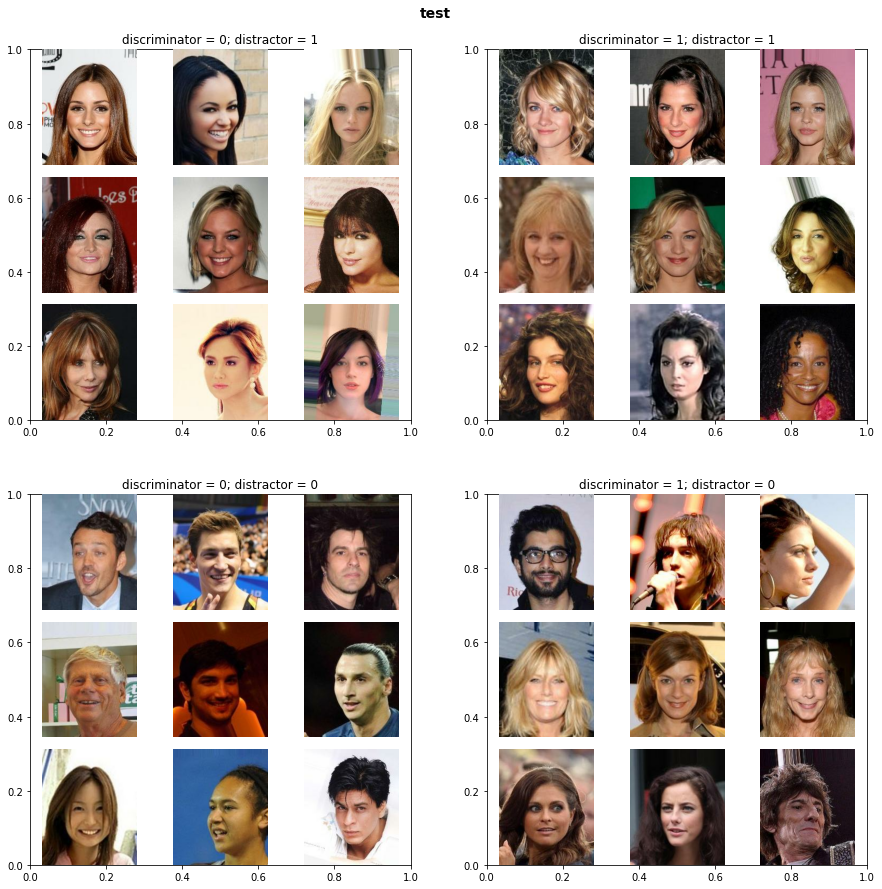

In [12]:
condition = ExposureCondition.CUE_CONFLICT.name.lower()

dataset_name = 'biased_exposure_celeb_a/' + cfg.name.replace(exposure_condition, condition)
for split in ['train', 'valid', 'test']:
    visualize_dataset(split,
                      tfds.load(dataset_name, split=split))
    print()
    print()

### Training condition: Partial exposure

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-train.tfrecord...:   0%|          | 0/39863 [00:00<?, ? examples/s]

Generating valid examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-valid.tfrecord...:   0%|          | 0/3883 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling biased_exposure_celeb_a-test.tfrecord...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Dataset biased_exposure_celeb_a downloaded and prepared to /Users/eringrant/tensorflow_datasets/biased_exposure_celeb_a/CelebA-partial_exposure-relative_balance-discriminator_Wavy_Hair-distractor_Heavy_Makeup/0.0.1. Subsequent calls will reuse this data.


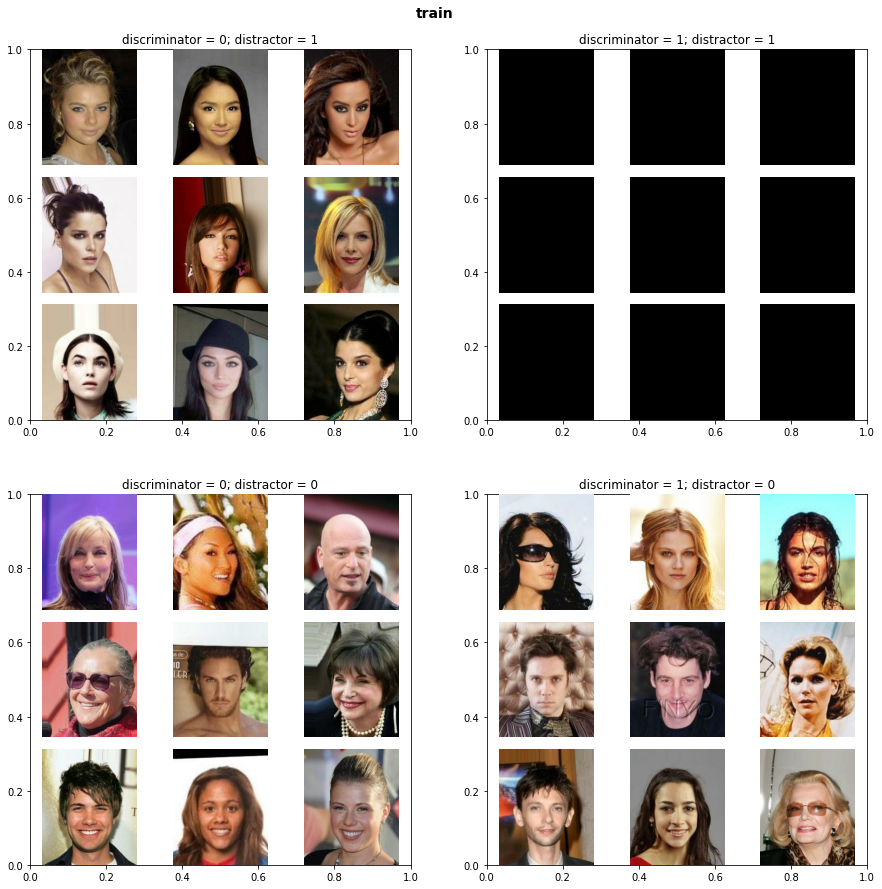

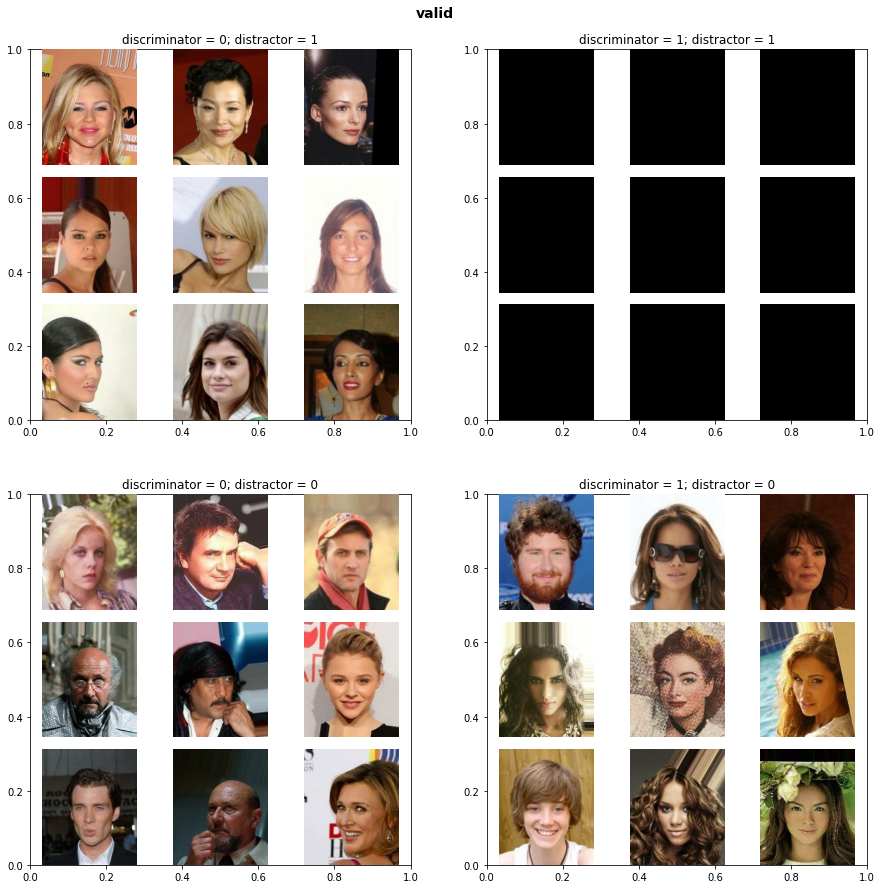

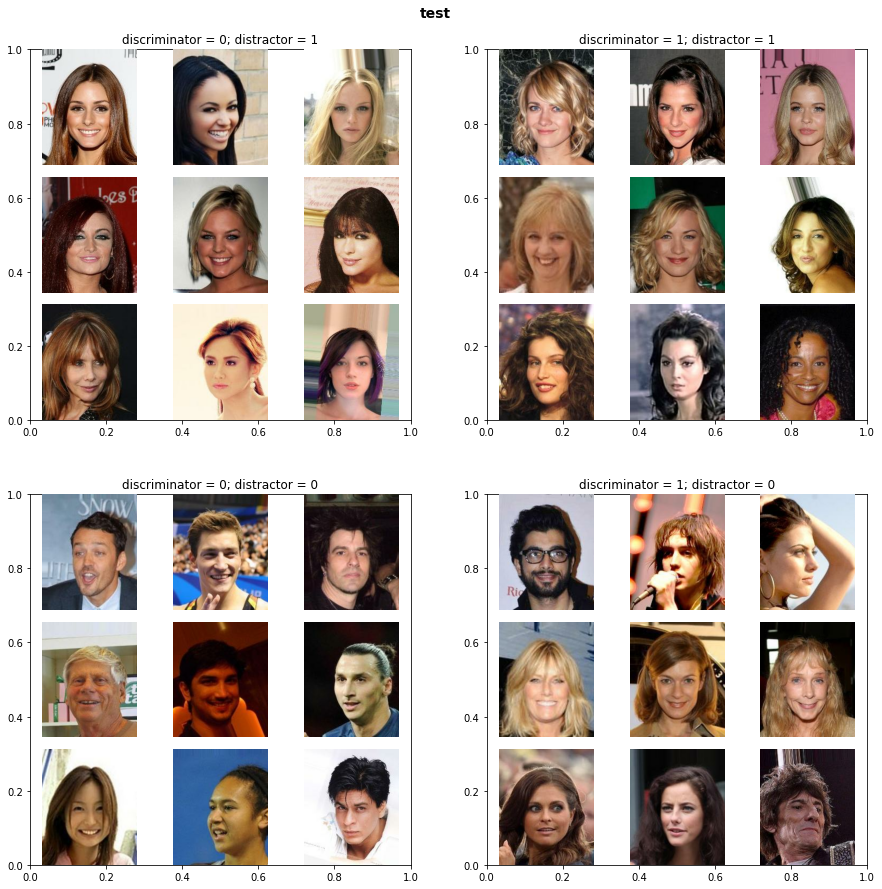

In [13]:
condition = ExposureCondition.PARTIAL_EXPOSURE.name.lower()

dataset_name = 'biased_exposure_celeb_a/' + cfg.name.replace(exposure_condition, condition)
for split in ['train', 'valid', 'test']:
    visualize_dataset(split,
                      tfds.load(dataset_name, split=split))
    print()
    print()

## Part II: Sanity-check attribute combinations

Loop through all generated configurations.

In [14]:
for cfg in sorted(BiasedExposureCelebA.BUILDER_CONFIGS, key=lambda c: c.name):
    dataset = BiasedExposureCelebA(config=cfg)
    print(cfg.name)
    split = 'valid'
    visualize_dataset(split,
                      dataset.as_dataset()[split],
                      4,
                     )
    print()
    print()

CelebA-cue_conflict-relative_balance-discriminator_Heavy_Makeup-distractor_High_Cheekbones


AssertionError: Dataset biased_exposure_celeb_a: could not find data in /Users/eringrant/tensorflow_datasets. Please make sure to call dataset_builder.download_and_prepare(), or pass download=True to tfds.load() before trying to access the tf.data.Dataset object.